# Projections de reports de votes

<div style="text-align: right"> André Mounier </div>

---
Étude des retraits de candidatures

In [1]:
import pandas as pd
import os
import tqdm
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Récupération des données de votes
Source : [Ministère de l'intérieur](www.resultats-elections.interieur.gouv.fr)

In [2]:
circonscriptions = pd.read_excel(os.path.join('input','circo_composition.xlsx'), sheet_name='table')
circonscriptions = circonscriptions.drop_duplicates('circo')
circonscriptions = circonscriptions[['DEP','REG','circo']]

Circonscriptions des départements métropolitains et départements d'outre-mer (il manque les 8 circonscriptions des collectivités d'outre-mer et les 11 circonscriptions des Français établis hors de France).

In [3]:
circonscriptions

,DEP,REG,circo
0,01,84,01004
1,01,84,01005
4,01,84,01003
6,01,84,01002
14,01,84,01001
...,...,...,...
35106,974,4,97403
35108,974,4,97404
35110,974,4,97402
35113,974,4,97406


In [17]:
# initialisation du tableau de résultat des votes
results_votes = None
save_path = os.path.join('output','votes_T1')
Path(save_path).mkdir(parents=True, exist_ok=True)
save_name = 'results_votes.csv'

test = 0

if save_name not in os.listdir(save_path):
    for i in tqdm.tqdm(range(len(circonscriptions))):
        # données administratives
        dep,reg,circo = circonscriptions[['DEP','REG','circo']].iloc[i].values
        reg = '{:02d}'.format(reg)

        if isinstance(circo, float):
            continue
        
        if circo[2]=='0':
            circo = list(circo)
            circo = circo[:2] + circo[3:]
            circo = ''.join(circo)

        # gestion manuelle des erreurs
        if circo in ['4907']:
            continue
    
        # lien vers les résultats
        url = 'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/{}/{}/{}/index.html'.format(reg,dep,circo)
        data_candidats, data_votants = pd.read_html(url)
        
        # récupération du nombre d'inscrits, de votants, de blancs, d'exprimés et de nuls
        inscrits, abstentions, votants, blancs, nuls, exprimes = [int(e.replace('\u202f','')) for e in data_votants.Nombre.values]
        
        # données de votes
        data_candidats = data_candidats[['Liste des candidats','Nuance','Voix','Elu(e)']]
        data_candidats['Voix'] = [int(e.replace('\u202f','')) for e in data_candidats.Voix]
        data_candidats['pourcentage_inscrits'] = data_candidats.Voix/inscrits
        data_candidats['pourcentage_exprimes'] = data_candidats.Voix/exprimes
        data_candidats['abstentions'] = [abstentions]*len(data_candidats)
        data_candidats['circo'] = [circo]*len(data_candidats)
        data_candidats['dep'] = [dep]*len(data_candidats)
        data_candidats['reg'] = [reg]*len(data_candidats)
    
        # ajout au tableau de résultat
        if results_votes is None:
            results_votes = data_candidats
        else:
            results_votes = pd.concat([results_votes,data_candidats],ignore_index=True)

        test += 1

    missed = ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/52/49/4907/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/ZX/ZX01/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/975/97501/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/988/98801/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/988/98802/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98701/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98702/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98703/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/986/98601/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/06/976/97601/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/06/976/97602/index.html']
    
    missed += ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/ZZ/ZZ{:02d}/index.html'.format(i) for i in range(1,12)]
    missed += ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/44/55/55{:02d}/index.html'.format(i) for i in range(1,3)]
    
    for url in tqdm.tqdm(missed):
        dep,reg,circo = url.split('/')[-4:-1]
        data_candidats, data_votants = pd.read_html(url)
        
        # récupération du nombre d'inscrits, de votants, de blancs, d'exprimés et de nuls
        inscrits, abstentions, votants, blancs, nuls, exprimes = [int(e.replace('\u202f','')) for e in data_votants.Nombre.values]
        
        # données de votes
        data_candidats = data_candidats[['Liste des candidats','Nuance','Voix','Elu(e)']]
        data_candidats['Voix'] = [int(e.replace('\u202f','')) for e in data_candidats.Voix]
        data_candidats['pourcentage_inscrits'] = data_candidats.Voix/inscrits
        data_candidats['pourcentage_exprimes'] = data_candidats.Voix/exprimes
        data_candidats['abstentions'] = [abstentions]*len(data_candidats)
        data_candidats['circo'] = [circo]*len(data_candidats)
        data_candidats['dep'] = [dep]*len(data_candidats)
        data_candidats['reg'] = [reg]*len(data_candidats)
    
        # ajout au tableau de résultat
        if results_votes is None:
            results_votes = data_candidats
        else:
            results_votes = pd.concat([results_votes,data_candidats],ignore_index=True)
        
        test +=1 
        
    results_votes = results_votes.reset_index().drop(columns='index')
    results_votes = results_votes.drop_duplicates()
    results_votes.to_csv(os.path.join(save_path, save_name), index=False)
            
results_votes = pd.read_csv(os.path.join(save_path, save_name))

In [18]:
winners = results_votes.groupby('circo')['Voix'].idxmax()
winners_idx = {k:int(v) for k,v in zip(winners.index, winners.values)}
winners_nuance = {k:results_votes.iloc[v]['Nuance'] for k,v in winners.items()}

print('Récupération des résultats de {} circonscriptions sur 577.'.format(len(winners)))

Récupération des résultats de 577 circonscriptions sur 577.


#### Carte des résultats

In [19]:
def draw_blank_map():
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    
    # découpage aux bordures du territoire métropolitain
    ax.set_extent([-5, 9.8, 41.3, 51.3])

    # ajout des frontières et autres éléments
    ax.add_feature(cfeature.OCEAN, color='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.RIVERS, edgecolor='lightgrey', zorder=-2)
    
    return fig,ax

In [20]:
codes_nuances = {'dg':['EXG','DVG'],
                 'fp':['UG','COM','FI','SOC','RDG','VEC','ECO'],
                 'en':['REN','MDM','HOR','ENS','DVC','UDI'],
                 'lr':['LR','DVD'],
                 'rn':['DSV','RN','UXD','EXD'],
                 're':['REC'],
                 'au':['REG','DIV'],
                 'abs':[]}

codes_nuances_inverted = dict()
for k,v in codes_nuances.items():
    for val in v:
        codes_nuances_inverted[val] = k

colors_nuances = {'dg':'tomato',
                  'fp':'tab:red',
                  'en':'tab:orange',
                  'lr':'tab:blue',
                  'rn':'tab:brown',
                  're':'darkblue',
                  'au':'grey',}

In [21]:
circonscriptions_geom = gpd.read_file(os.path.join('input','contours_circonscriptions_legislatives_03052022','circonscriptions_legislatives_030522.shp'))
circonscriptions_geom = circonscriptions_geom.to_crs("epsg:3395")

winners_color = {k:colors_nuances.get(codes_nuances_inverted.get(v)) for k,v in winners_nuance.items()}
circonscriptions_geom['color'] = [winners_color.get(circo, 'w') for circo in circonscriptions_geom.id_circo]

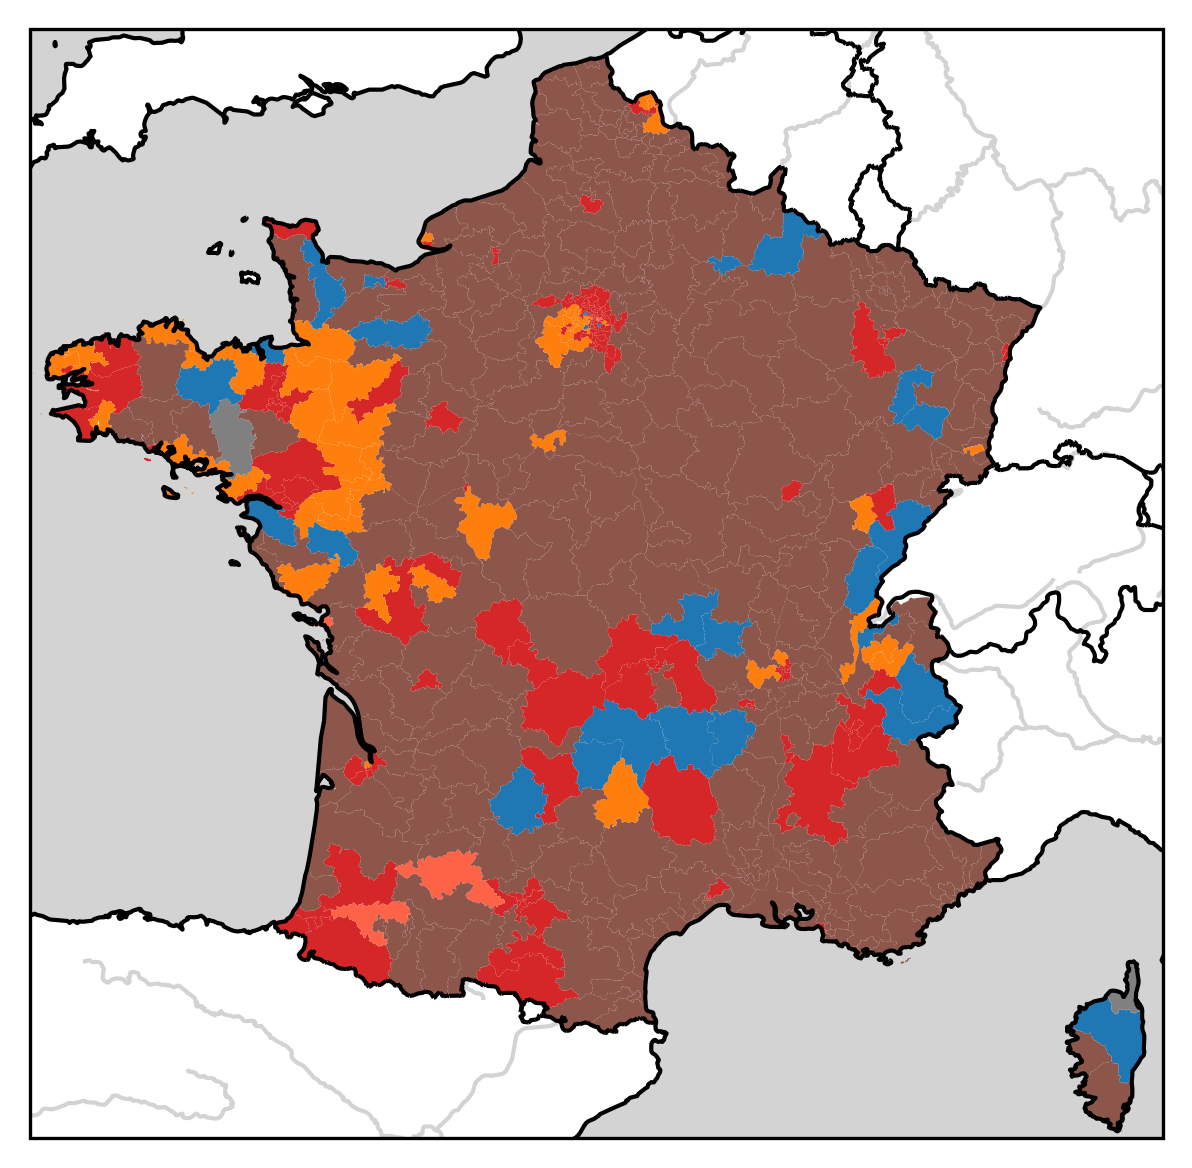

In [22]:
fig,ax  = draw_blank_map()
circonscriptions_geom.plot(color=circonscriptions_geom.color, ax=ax)
plt.show()

### Récupération des reports de votes estimés de 2022 
Source : [Harris Interactive](https://harris-interactive.fr/wp-content/uploads/sites/6/2022/06/Harris-x-Toluna-pour-M6-et-RTL-Jour-du-vote-au-2nd-tour-des-elections-legislatives-2022.pdf) (réutilisation dans [Ouest-France](https://www.ouest-france.fr/elections/legislatives/legislatives-2022-nupes-rn-ensemble-comment-s-est-effectue-le-report-des-voix-au-second-tour-47e09e78-f09b-11ec-a1f9-96fad4cda185))

In [23]:
matrix_fp_en = {'fp':{'fp':0.91,'en':0.05,'abs':0.04},
                'dg':{'fp':0.53,'en':0.29,'abs':0.18},
                'en':{'fp':0.02,'en':0.96,'abs':0.02},
                'lr':{'fp':0.09,'en':0.64,'abs':0.27},
                'rn':{'fp':0.24,'en':0.25,'abs':0.51},
                're':{'fp':0.15,'en':0.24,'abs':0.61},
               }

matrix_rn_en = {'fp':{'rn':0.24,'en':0.31,'abs':0.45},
                'dg':{'rn':0.36,'en':0.34,'abs':0.30},
                'en':{'rn':0.05,'en':0.92,'abs':0.03},
                'lr':{'rn':0.32,'en':0.49,'abs':0.19},
                'rn':{'rn':0.94,'en':0.02,'abs':0.04},
                're':{'rn':0.83,'en':0.00,'abs':0.17},
               }

matrix_fp_rn = {'fp':{'fp':0.89,'rn':0.07,'abs':0.04},
                'dg':{'fp':0.56,'rn':0.17,'abs':0.27},
                'en':{'fp':0.34,'rn':0.18,'abs':0.48},
                'lr':{'fp':0.36,'rn':0.27,'abs':0.37},
                'rn':{'fp':0.04,'rn':0.95,'abs':0.01},
                're':{'fp':0.10,'rn':0.77,'abs':0.13},
               }

### Projections de votes au second tour

Cinq scénarios testés :
1. Aucun désistement
2. Désistement systématique des candidats NFP arrivés en 3e position
3. Désistement systématique des candidats ENS arrivés en 3e position
4. Désistement systématique des candidats ENS arrivés en 3e position (sauf si LFI)
5. Désistements optimaux pour faire barrage au RN, par les reports de votes de 2022